# Exploring ERA5 collection using tensorlakehouse

### Data description
* Collection/dataset:"global-weather-era5"

### Functionalities
* tensorlakehouse (openEO) functionalities:
    - describe collection
    - load collection

### Setup

1. Create a python virtualenv (python 3.11.7 is the recommended version). 
2. Clone the repository:
```
git clone https://github.com/IBM/tensorlakehouse-openeo-driver.git
``` 

3. Go to
```
cd tensorlakehouse-openeo-driver/tutorials
```

4. Install dependencies:
```
pip install -r tutorial_requirements.txt
```

5. Run jupyter notebook or jupyter lab
```
jupyter lab .
```


In [1]:
import rioxarray as rxr
import os
os.environ['USE_PYGEOS'] = '0'
import matplotlib.pyplot as plt
from pathlib import Path
# openeo is a client-side implementation that allows users to query OpenEO service
import openeo
# pystac_client is a client-side implementation that allows users to query STAC service
from pystac_client import Client
# OpenEO service URL
import os
from dotenv import load_dotenv
import pandas as pd
import json
import xarray as xr
import requests

In [3]:
load_dotenv()

STAC_URL="https://stac-fastapi-pgstac-geodn-discovery.cimf-staging-9ca4d14d48413d18ce61b80811ba4308-0000.us-south.containers.appdomain.cloud"
OPENEO_URL="https://tensorlakehouse-openeo-driver-geodn-discovery.cimf-staging-9ca4d14d48413d18ce61b80811ba4308-0000.us-south.containers.appdomain.cloud"
OIDC_AUTH = True

### STAC authentication

If you want to connect to a STAC instance that requires authentication, you must set the [environment variables](https://github.com/IBM/tensorlakehouse-openeo-driver/?tab=readme-ov-file#setting-environment-varibles) and then you can the use the following function to get the token:

In [4]:
def sign_request(request: requests.Request) -> requests.Request:
    appid_issuer = os.environ["APPID_ISSUER"]
    username = os.environ["APPID_USERNAME"]
    password = os.environ["APPID_PASSWORD"]
    client_id = os.environ["OPENEO_AUTH_CLIENT_ID"]
    client_secret = os.environ["OPENEO_AUTH_CLIENT_SECRET"]

    token_url = f"{appid_issuer}/token"
    headers = {"Accept": "application/json"}
    payload = {
        "grant_type": "password",
        "username": username,
        "password": password,
    }
    auth = (client_id, client_secret)
    resp = requests.post(token_url, headers=headers, auth=auth, json=payload)
    resp.raise_for_status()
    tokens = resp.json()
    access_token = tokens["access_token"]
    request.headers["Authorization"] = f"Bearer {access_token}"
    return request



but if you want to connect to a STAC instance that does not require any auth, you don't need 

In [5]:
if OIDC_AUTH:
    catalog = Client.open(
        url=STAC_URL,
        request_modifier=sign_request
    )
else:
    catalog = Client.open(STAC_URL)

### List collections

In [24]:
for collection in catalog.get_collections():
    print(collection.id)

esa-sentinel-2A-msil1c
HLSS30
global-weather-era5
dev_ne_10m_admin_0_countries
gedi-l2a
atmospheric-era5
test-gedi-l2a
atmospheric-weather-era5
ds335-sentinel1
sentinel-1-grd
dev_kaggle_wildfire
Radar
Radar-10min
tasmax-rcp85-land-cpm-uk-2.2km
ibm-eis-ga-1-era5-pr-wdc
vector-osm-power
vector-osm-building
vector-osm-poi
vector-osm-road
vector-osm-natural
vector-osm-railway
vector-osm-boundary
vector-osm-landuse
vector-osm-waterway
ibm-eis-ga-1-esa-sentinel-2-l2a


STACTypeError: JSON (id = HLSL30_version2) does not represent a CollectionClient instance.

### Setting collection, temporal extent and spatial extent

In [12]:
start = "2023-03-08T00:00:00Z"
end = "2023-03-08T12:00:00Z"

north = 55.0
south = 50.0
east = 3.0
west = -2.0

collection_id = "global-weather-era5"

### Searching STAC items based on area of interest (bbox), temporal extent and collection

In [13]:
bbox = [west, south, east, north]
results = catalog.search(collections=[collection_id], bbox=bbox, datetime=[start, end], limit=1000)

In [14]:
for item in results.items_as_dicts():
    item_id = item["id"]
    bbox = item["bbox"]
    item_prop = item["properties"]
    cube_dims = item_prop.get("cube:dimensions")
    dt = item_prop.get("datetime")
    start_dt = item_prop.get("start_datetime")
    end_dt = item_prop.get("end_datetime")
    print(f"{item_id=} {bbox=} {cube_dims=} {dt=} {start_dt=} {end_dt=}")
    
    
    

item_id='global-weather-era5' bbox=[-180.0, -90.0, 180.0, 90.0] cube_dims={'x': {'axis': 'x', 'step': 0.000128, 'type': 'spatial', 'extent': [-180.0, 180.0], 'reference_system': 4326}, 'y': {'axis': 'y', 'step': 0.000128, 'type': 'spatial', 'extent': [-90.0, 90.0], 'reference_system': 4326}, 'time': {'type': 'temporal', 'extent': ['1980-01-01T12:00:00.000Z', None]}} dt=None start_dt='1980-01-01T12:00:00.000Z' end_dt='2024-01-26T00:00:00.000Z'


### Connecting to tensorlakehouse-openEO

In [15]:
if OIDC_AUTH:
    ### Connecting to tensorlakehouse-openEO using OIDC auth
    appid_issuer = os.environ["APPID_ISSUER"]
    username = os.environ["APPID_USERNAME"]
    password = os.environ["APPID_PASSWORD"]
    client_id = os.environ["OPENEO_AUTH_CLIENT_ID"]
    client_secret = os.environ["OPENEO_AUTH_CLIENT_SECRET"]
    
    openeo_conn = openeo.connect(
        OPENEO_URL
    ).authenticate_oidc_resource_owner_password_credentials(
        username=username,
        password=password,
        client_id=client_id,
        client_secret=client_secret,
        provider_id="app_id",
    )

else:
    # basic auth
    username = os.environ["OPENEO_USERNAME"]
    password = os.environ["OPENEO_PASSWORD"]
    
    # authenticate using basic auth
    openeo_conn = openeo.connect(OPENEO_URL).authenticate_basic(username, password)

Setting collection, temporal extent and area of interest

In [16]:
spatial_extent={
        'west' : west,
        'south' : south,
        'east' : east,
        'north' : north
    }

temporal_extent=[start, end]
# create data dir to save files
data_dir = Path("test_data")
if not data_dir.exists():
    data_dir.mkdir()

### Describing a collection

In [17]:
openeo_conn.describe_collection(collection_id)

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['100 meter wind towards east',
    '100 meter wind towards north',
    '10 meter wind gust (maximum)',
    '10 meter wind towards east',
    '10 meter wind towards north',
    'Dewpoint',
    'Temperature',
    'Solar radiation (total sky)',
    'High cloud cover',
    '10 meter wind gust (instantaneous)',
    'Low cloud cover',
    'Medium cloud cover',
    'Minimum temperature',
    'Maximum temperature',
    'Minimum precipitation rate',
    'Maximum precipitation rate',
    'Mean sea level pressure',
    'Precipitation type',
    'Snow density',
    'Snow depth',
    'Snowfall',
    'Surface pressure',
    'Solar radiation',
    'Solar radiation (clear sky)',
    'Sea surface temperature',
    'Soil temperature (0 to 7 cm)',
    'Soil temperature (7 to 21 cm)',
    'Soil temperature (21 to 72 cm)',
    'Soil temperature (72 to 189 cm)',
    'Thermal radiation',
    'Thermal radiation (clear sky)',
    'Soil water (0 to 7 cm)',
    'Soil water (7 to 21 cm)',
    'Soil water (21 to 72 cm)',
    'Soil water (72 to 189 cm)',
    'Total cloud cover',
    'Rain water content of atmosphere',
    'Snow water content of atmosphere',
    'Atmospheric water content',
    'Atmospheric water vapor content',
    'Total precipitation',
    'Solar radiation (top of atmosphere)',
    'Solar radiation (top of atmosphere) (clear sky)',
    'Thermal radiation (top of atmosphere)',
    'Thermal radiation (top of atmosphere) (clear sky)',
    'Wave height',
    'Wave direction',
    'Wave period',
    'Lake cover',
    'Lake depth',
    'Low vegetation cover',
    'High vegetation cover',
    'Type of low vegetation',
    'Type of high vegetation',
    'Soil type',
    'Sub grid scale elevation (standard deviation)',
    'Gravitational potential energy',
    'Standard deviation of orography',
    'Anisotropy of sub grid scale orography',
    'Angle of sub grid scale orography',
    'Slope of sub grid scale orography',
    'Land sea mask']},
  'time': {'extent': ['1980-01-01T12:00:00+00:00', None], 'type': 'temporal'},
  'x': {'axis': 'x', 'extent': [-180.0, 180.0], 'type': 'spatial'},
  'y': {'axis': 'y', 'extent': [-90.0, 90.0], 'type': 'spatial'}},
 'deprecated': False,
 'description': 'ERA5 is the direct successor to the ERA Interim reanalsis. It provides global, hourly data at a resolution of 0.25 by 0.25 degrees. As any reanalysis product, ERA5 combines observed data with the output of meteorological models. Note that there are actually two versions of ERA5 data. Initial data is referred to as ERA5T and available in near real time. I.e., ERA5T data lags real time by about three days. About three months later, the final version of the data is released. This is the actual ERA5 data. This dataset contains both ERA5 and ERA5T data. With the latter being uploaded initially and overwritten once the former is available. As far as currently known, differences between the two versions are negligible.',
 'extent': {'spatial': {'bbox': [[-180.0, -90.0, 180.0, 90.0]]},
  'temporal': {'interval': [['1980-01-01T12:00:00Z', None]]}},
 'id': 'global-weather-era5',
 'keywords': [],
 'license': 'proprietary',
 'links': [{'href': 'http://stac-fastapi-pgstac.geodn-discovery.svc.cluster.local:8080/collections/global-weather-era5/items',
   'rel': 'items',
   'type': 'application/geo+json'},
  {'href': 'http://stac-fastapi-pgstac.geodn-discovery.svc.cluster.local:8080/',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geodn-discovery.svc.cluster.local:8080/',
   'rel': 'root',
   'title': 'stac-fastapi',
   'type': 'application/json'},
  {'href': 'http://stac-fastapi-pgstac.geodn-discovery.svc.cluster.local:8080/collections/global-weather-era5',
   'rel': 'self',
   'type': 'application/json'}],
 'providers': [{'description': 'Producers of awesome spatiotemporal assets',
   'name': 'IBM',
   'roles': ['producer', 'processor'],
   'url': 'https://www.ibm.com'

## Loading a collection 

In [18]:
# set bands
bands = ["Temperature"]
print(f"{collection_id=} {spatial_extent=} {temporal_extent=} {bands=}")
# loading collection
cube = openeo_conn.load_collection(
    collection_id=collection_id,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=bands
)


collection_id='global-weather-era5' spatial_extent={'west': -2.0, 'south': 50.0, 'east': 3.0, 'north': 55.0} temporal_extent=['2023-03-08T00:00:00Z', '2023-03-08T12:00:00Z'] bands=['Temperature']


In [19]:
output_format = "netCDF"
merged_cube = cube.save_result(output_format)

print(json.loads(cube.to_json()))

{'process_graph': {'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['Temperature'], 'id': 'global-weather-era5', 'spatial_extent': {'west': -2.0, 'south': 50.0, 'east': 3.0, 'north': 55.0}, 'temporal_extent': ['2023-03-08T00:00:00Z', '2023-03-08T12:00:00Z']}, 'result': True}}}


In [20]:
filename = f'{collection_id}.nc'

# delete file if it already exists
path = data_dir / filename
if path.exists():
    path.unlink()
# measure elapsed time
start = pd.Timestamp.now()
print(f"Start the download at {start}")
# download file
try:
    cube.download(path)
except OpenEoApiError as e:
    now = pd.Timestamp.now()
    print(f"Failed to dowload: {now}")
    raise e
end = pd.Timestamp.now()
elapsed_time = end - start
print(f"{end.isoformat()} Downloaded file: {path} elapsed time={elapsed_time}")

Preflight process graph validation failed: [403] AuthenticationSchemeInvalid: Authentication method not supported. (ref: r-2406111f18cc4ac08bc4e8ce57e1639d)


Start the download at 2024-06-10 22:05:49.753361
2024-06-10T22:06:05.228366 Downloaded file: test_data/global-weather-era5.nc elapsed time=0 days 00:00:15.475005


### Opening the file downloaded from tensorlakehouse-openEO

In [21]:
ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 159kB
Dimensions:      (time: 13, y: 39, x: 39)
Coordinates:
  * time         (time) datetime64[ns] 104B 2023-03-08 ... 2023-03-08T12:00:00
  * y            (y) float64 312B 55.03 54.9 54.77 54.64 ... 50.31 50.18 50.05
  * x            (x) float64 312B -1.939 -1.808 -1.677 ... 2.78 2.911 3.042
Data variables:
    Temperature  (time, y, x) float64 158kB ...
    spatial_ref  int64 8B ...
Attributes:
    grid_type:         pairs
    resolution_level:  12

In [22]:
# open all raster files and concatenate
da = ds[bands[0]]
da

<xarray.DataArray 'Temperature' (time: 13, y: 39, x: 39)> Size: 158kB
[19773 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 104B 2023-03-08 ... 2023-03-08T12:00:00
  * y        (y) float64 312B 55.03 54.9 54.77 54.64 ... 50.44 50.31 50.18 50.05
  * x        (x) float64 312B -1.939 -1.808 -1.677 -1.545 ... 2.78 2.911 3.042
Attributes:
    grid_mapping:  spatial_ref

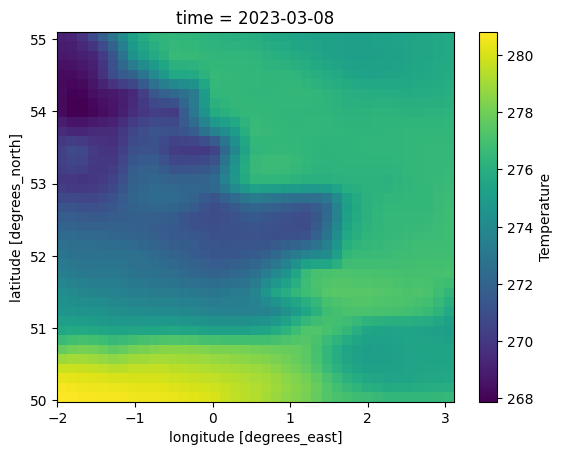

In [23]:
da.isel({"time": 0}).plot()